# ADA Boost for trees

### Importing Libraries 

In [1]:
import numpy as np 
from sklearn.tree import DecisionTreeClassifier
import pickle
from scipy.stats import chi2
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
np.random.seed(0)

### Function Definitions

In [2]:
def ada_boost_trees(X_train, y_train, M):
    '''
    Returns a list of M models, each model is a tuple of a DecisionTreeClassifier and its weight alpha_m
    '''
    N = len(X_train)

    #weights to 1/N
    weights = np.ones(N) / N
    ALL_G_models = []
    for m in range(0,M):
        G_m = DecisionTreeClassifier(max_depth=1) #max_depth=1 for stump (Two terminal node classification tree)
        G_m.fit(X_train, y_train, sample_weight=weights)

        #calculate err_m
        numerator = 0
        for i in range(0,N):
            if G_m.predict(X_train[i:i+1,:])[0] != y_train[i]:
                numerator += weights[i]
        err_m = numerator / np.sum(weights)
        #calculate alpha_m
        alpha_m = np.log((1-err_m)/err_m)
        #update weights
        for i in range(0,N):
            pred = G_m.predict(X_train[i:i+1,:])[0]
            if pred != y_train[i]:
                weights[i] = weights[i] * np.exp(alpha_m)
        weights /= np.sum(weights)
        #save G_m using pickle
        ALL_G_models.append([pickle.loads(pickle.dumps(G_m)), alpha_m])
    return ALL_G_models

def predict(X, models):
    '''
    Returns the predictions of the models on any input X
    '''
    N = len(X)
    M = len(models)
    y_pred = np.zeros(N)
    for i in range(0,N):
        for m in range(0,M):
            y_pred[i] += models[m][0].predict(X[i:i+1,:])[0] * models[m][1]
    y_pred = np.sign(y_pred)
    return y_pred

### Reproducing Figure 10.2

#### Problem Settings (Defining X_train, y_train, X_test, y_test)!

In [4]:
# Parameters
N_train = 2000  # number of training samples
N_test = 10000  # number of test samples
N_features = 10  # number of features

# Chi-squared threshold with 10 degrees of freedom
chi2_threshold = chi2.ppf(0.5, df=10) # 9.34


X_train = np.random.randn(N_train, N_features)
X_test = np.random.randn(N_test, N_features)

# Define the target variable Y
def compute_y(X):
    sum_squares = np.sum(X**2, axis=1)
    return np.where(sum_squares > chi2_threshold, 1, -1) # 1 if sum_squares > 9.34, -1 otherwise

y_train = compute_y(X_train)
y_test = compute_y(X_test)
boosting_iterations = np.arange(0,401,5) # array of M's [M1,M2,M3,...] so we will be training our boosting model on each of these M values
boosting_iterations[0] = 1 # since we can't have 0 boosting iterations ( we have at least 1 corresponding to a single decision tree)
#Defining our arrays to store the testing errors for each M

Non-Parallel Code

In [60]:

TEST_ERROR = np.zeros(len(boosting_iterations))
TRAIN_ERROR = np.zeros(len(boosting_iterations))
for i,M in enumerate(boosting_iterations):
    models = ada_boost_trees(X_train, y_train, M)
    y_pred = predict(X_test, models)
    TEST_ERROR[i] = np.sum(y_pred != y_test) / N_test
    y_pred = predict(X_train, models)
    TRAIN_ERROR[i] = np.sum(y_pred != y_train) / N_train
    print(f'M = {M}, Test Error = {TEST_ERROR[i]}, Train Error = {TRAIN_ERROR[i]}')
np.save('TEST_ERROR.npy', TEST_ERROR)
np.save('TRAIN_ERROR.npy', TRAIN_ERROR)

M = 1, Test Error = 0.4548, Train Error = 0.456
M = 5, Test Error = 0.392, Train Error = 0.3745
M = 10, Test Error = 0.348, Train Error = 0.314
M = 15, Test Error = 0.3695, Train Error = 0.3495
M = 20, Test Error = 0.3105, Train Error = 0.2695
M = 25, Test Error = 0.2768, Train Error = 0.2395
M = 30, Test Error = 0.26, Train Error = 0.215
M = 35, Test Error = 0.2648, Train Error = 0.229
M = 40, Test Error = 0.204, Train Error = 0.173
M = 45, Test Error = 0.2382, Train Error = 0.2005
M = 50, Test Error = 0.2125, Train Error = 0.1705
M = 55, Test Error = 0.2062, Train Error = 0.1585
M = 60, Test Error = 0.1938, Train Error = 0.144
M = 65, Test Error = 0.204, Train Error = 0.1595
M = 70, Test Error = 0.1862, Train Error = 0.149
M = 75, Test Error = 0.1816, Train Error = 0.139
M = 80, Test Error = 0.1903, Train Error = 0.135
M = 85, Test Error = 0.172, Train Error = 0.121
M = 90, Test Error = 0.176, Train Error = 0.124
M = 95, Test Error = 0.1636, Train Error = 0.115
M = 100, Test Error = 

#### Parallelized Code

In [ ]:
boosting_iterations_3 = np.arange(0,2001,100)
boosting_iterations_3[0] = 1 
def train_and_evaluate(M, X_train, y_train, X_test, y_test):
    models = ada_boost_trees(X_train, y_train, M)
    y_pred = predict(X_test, models)
    test_error = np.sum(y_pred != y_test) / len(y_test)
    print(f'M={M}, Test Error={test_error}')
    return test_error
TEST_ERROR_3= Parallel(n_jobs=-1)(delayed(train_and_evaluate)(M, X_train, y_train, X_test, y_test) for M in boosting_iterations_3)
np.save('TEST_ERROR_3.npy', TEST_ERROR_3)

#### Finding 244 nodes trees in python !

In [72]:
def best_leaf_nodes_number(X_train, y_train,target_nodes,a=100,b=300):
    '''
    returns the best number of leaf nodes for a decision tree classifier that has the closest number of nodes to the target_nodes in the range of [a,b)
    '''
    def count_nodes(tree):
        return tree.tree_.node_count

    best_diff = float('inf')
    best_tree = None
    best_leaf_nodes = None

    for max_leaf_nodes in range(a, b): 
        tree = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes)
        tree.fit(X_train, y_train)
        num_nodes = count_nodes(tree)
        diff = abs(num_nodes - target_nodes)
        if diff < best_diff:
            best_diff = diff
            best_tree = tree
            best_leaf_nodes = max_leaf_nodes
            # print(f"Better match found: {num_nodes} nodes with max_leaf_nodes= {max_leaf_nodes}")
        
        if num_nodes == target_nodes:
            # print(f"Exact match found: {num_nodes} nodes with max_leaf_nodes= {max_leaf_nodes}")
            break
    return best_leaf_nodes
best_leaf_nodes = best_leaf_nodes_number(X_train, y_train, 244)
TREE = DecisionTreeClassifier(max_leaf_nodes=best_leaf_nodes)
TREE.fit(X_train, y_train)
y_pred = TREE.predict(X_test)
test_error_244 = np.sum(y_pred != y_test) / N_test
y_pred = TREE.predict(X_train)
train_error_244 = np.sum(y_pred != y_train) / N_train


#### Plotting Fig 10.2

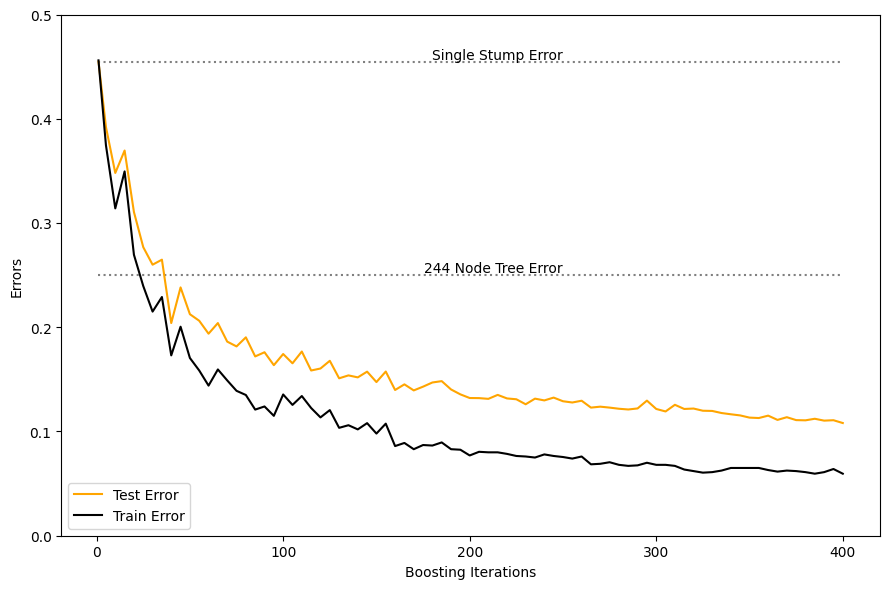

In [94]:
# Getting the single stump error

TEST_ERROR = np.load('TEST_ERROR.npy')
single_stump_test_error = TEST_ERROR[0] # the first element in the array is the error of a single stump
TRAIN_ERROR = np.load('TRAIN_ERROR.npy')


plt.figure(figsize=(9,6))
plt.plot(boosting_iterations, np.ones(len(boosting_iterations))*single_stump_test_error, linestyle='dotted',color='grey')
plt.plot(boosting_iterations, np.ones(len(boosting_iterations))*test_error_244,linestyle = 'dotted',color='grey')
plt.plot(boosting_iterations, TEST_ERROR, label='Test Error',color='orange')
plt.plot(boosting_iterations, TRAIN_ERROR, label='Train Error',color='black')
plt.text(250, single_stump_test_error, 'Single Stump Error', va='bottom', ha='right', color='black')
plt.text(250, test_error_244, '244 Node Tree Error', va='bottom', ha='right', color='black')
plt.yticks(np.arange(0, 0.6, step=0.1))
plt.xticks(np.arange(0, 401, step=100))
plt.xlabel('Boosting Iterations')
plt.ylabel('Errors')
plt.legend()

plt.tight_layout()
plt.show()

## Figure for Comparison between TEST error and boosting iterations

#### Non-Parallel Code For doing it (takes so much time!)

In [ ]:
boosting_iterations_2 = np.arange(405,1001,5) 
TEST_ERROR_2 = np.zeros(len(boosting_iterations_2))
for i,M in enumerate(boosting_iterations_2):
    models = ada_boost_trees(X_train, y_train, M)
    y_pred = predict(X_test, models)
    TEST_ERROR_2[i] = np.sum(y_pred != y_test) / N_test
    print(f'M = {M}, Test Error = {TEST_ERROR_2[i]}')
np.save('TEST_ERROR_2.npy', TEST_ERROR_2)

#### Plotting the figure!

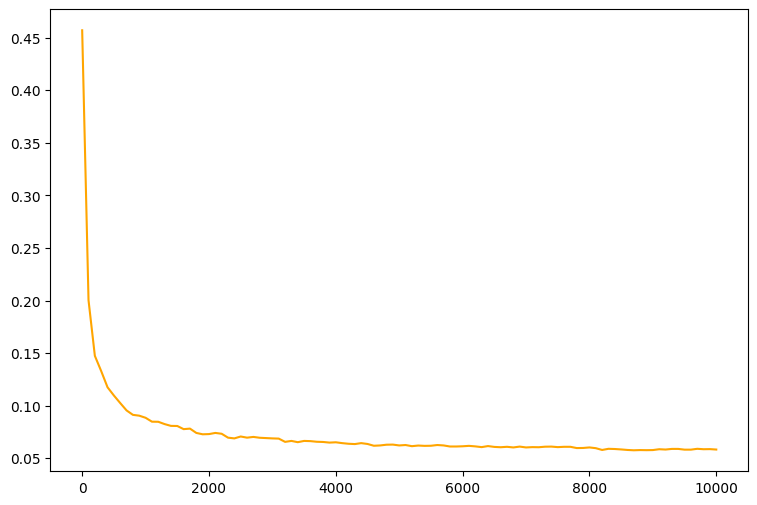

In [4]:
# TEST_ERROR = np.load('TEST_ERROR.npy')
# TEST_ERROR_2 = np.load('TEST_ERROR_2.npy')
# boosting_iterations_2 = np.arange(405,1001,5) 
# #concatenate TESTERROR and TESTERROR_2
# TEST_ERROR = np.concatenate((TEST_ERROR,TEST_ERROR_2))
# boosting_iterations = np.concatenate((boosting_iterations,boosting_iterations_2))
TEST_ERROR = np.load('TEST_ERROR_3.npy')

boosting_iterations_2 = np.arange(0,10001,100) 
#concatenate TESTERROR and TESTERROR_2

plt.figure(figsize=(9,6))
plt.plot(boosting_iterations_2,TEST_ERROR, label='Test Error',color='orange')
plt.show()

# Part D, Changing the Set-up

#### Code for HPC

In [ ]:
n_train_class1 = 1000  
n_train_class2 = 1000  
n_test = 10000  
n_features = 10  

def generate_class2_samples(n_samples, n_features, threshold):
    '''
    returns n_samples samples from class 2 where the sum of squares of the features is greater than threshold
    '''
    samples = []
    while len(samples) < n_samples:
        X = np.random.randn(1, n_features)
        if np.sum(X**2) > threshold:
            samples.append(X)
    return np.concatenate(samples, axis=0)


X_train_class1 = np.random.randn(n_train_class1, n_features)
y_train_class1 = np.ones(n_train_class1)  # Label for Class 1 is 1

threshold = 12
X_train_class2 = generate_class2_samples(n_train_class2, n_features, threshold)
y_train_class2 = -np.ones(n_train_class2)  # Label for Class 2 is -1


X_train = np.concatenate((X_train_class1, X_train_class2), axis=0)
y_train = np.concatenate((y_train_class1, y_train_class2), axis=0)


X_test_class1 = np.random.randn(n_test // 2, n_features)
y_test_class1 = np.ones(n_test // 2)

X_test_class2 = generate_class2_samples(n_test // 2, n_features, threshold)
y_test_class2 = -np.ones(n_test // 2)

X_test = np.concatenate((X_test_class1, X_test_class2), axis=0)
y_test = np.concatenate((y_test_class1, y_test_class2), axis=0)






boosting_iterations = np.arange(0,401,5) # array of M's [M1,M2,M3,...] so we will be training our boosting model on each of these M values
boosting_iterations[0] = 1 # since we can't have 0 boosting iterations ( we have at least 1 corresponding to a single decision tree)
#Defining our arrays to store the testing errors for each M

def train_and_evaluate(M, X_train, y_train, X_test, y_test):
    models = ada_boost_trees(X_train, y_train, M)
    y_pred = predict(X_test, models)
    test_error = np.sum(y_pred != y_test) / len(y_test)
    y_pred_train = predict(X_train, models)
    train_error = np.sum(y_pred_train != y_train) / len(y_train)
    return test_error,train_error
TEST_ERROR_s_2,TRAIN_ERROR_s_2= Parallel(n_jobs=-1)(delayed(train_and_evaluate)(M, X_train, y_train, X_test, y_test) for M in boosting_iterations)
np.save('TEST_ERROR_s_2.npy', TEST_ERROR_s_2)
np.save('TRAIN_ERROR_s_2.npy', TRAIN_ERROR_s_2)

#### Plotting the figure !

In [8]:
n_train_class1 = 1000  
n_train_class2 = 1000  
n_test = 10000  
n_features = 10  

def generate_class2_samples(n_samples, n_features, threshold):
    '''
    returns n_samples samples from class 2 where the sum of squares of the features is greater than threshold
    '''
    samples = []
    while len(samples) < n_samples:
        X = np.random.randn(1, n_features)
        if np.sum(X**2) > threshold:
            samples.append(X)
    return np.concatenate(samples, axis=0)


X_train_class1 = np.random.randn(n_train_class1, n_features)
y_train_class1 = np.ones(n_train_class1)  # Label for Class 1 is 1

threshold = 12
X_train_class2 = generate_class2_samples(n_train_class2, n_features, threshold)
y_train_class2 = -np.ones(n_train_class2)  # Label for Class 2 is -1


X_train = np.concatenate((X_train_class1, X_train_class2), axis=0)
y_train = np.concatenate((y_train_class1, y_train_class2), axis=0)


X_test_class1 = np.random.randn(n_test // 2, n_features)
y_test_class1 = np.ones(n_test // 2)

X_test_class2 = generate_class2_samples(n_test // 2, n_features, threshold)
y_test_class2 = -np.ones(n_test // 2)

X_test = np.concatenate((X_test_class1, X_test_class2), axis=0)
y_test = np.concatenate((y_test_class1, y_test_class2), axis=0)





def best_leaf_nodes_number(X_train, y_train,target_nodes,a=100,b=300):
    '''
    returns the best number of leaf nodes for a decision tree classifier that has the closest number of nodes to the target_nodes in the range of [a,b)
    '''
    def count_nodes(tree):
        return tree.tree_.node_count

    best_diff = float('inf')
    best_tree = None
    best_leaf_nodes = None

    for max_leaf_nodes in range(a, b): 
        tree = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes)
        tree.fit(X_train, y_train)
        num_nodes = count_nodes(tree)
        diff = abs(num_nodes - target_nodes)
        if diff < best_diff:
            best_diff = diff
            best_tree = tree
            best_leaf_nodes = max_leaf_nodes
            # print(f"Better match found: {num_nodes} nodes with max_leaf_nodes= {max_leaf_nodes}")
        
        if num_nodes == target_nodes:
            # print(f"Exact match found: {num_nodes} nodes with max_leaf_nodes= {max_leaf_nodes}")
            break
    return best_leaf_nodes
best_leaf_nodes = best_leaf_nodes_number(X_train, y_train, 244)
TREE = DecisionTreeClassifier(max_leaf_nodes=best_leaf_nodes)
TREE.fit(X_train, y_train)
y_pred = TREE.predict(X_test)
test_error_244 = np.sum(y_pred != y_test) / n_test
y_pred = TREE.predict(X_train)
train_error_244 = np.sum(y_pred != y_train) / (n_train_class1+n_train_class2)

boosting_iterations = np.arange(0,401,5) # array of M's [M1,M2,M3,...] so we will be training our boosting model on each of these M values
boosting_iterations[0] = 1


# Getting the single stump error

TEST_ERROR_s_2 = np.load('TEST_ERROR_s_2.npy')
single_stump_test_error = TEST_ERROR_s_2[0] # the first element in the array is the error of a single stump
TRAIN_ERROR_s_2 = np.load('TRAIN_ERROR_s_2.npy')




PLotting 

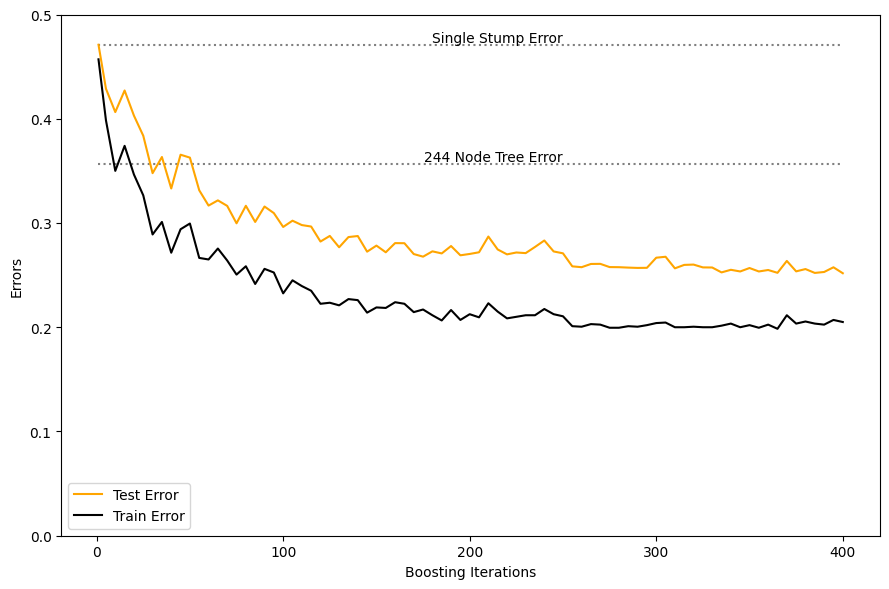

In [7]:
plt.figure(figsize=(9,6))
plt.plot(boosting_iterations, np.ones(len(boosting_iterations))*single_stump_test_error, linestyle='dotted',color='grey')
plt.plot(boosting_iterations, np.ones(len(boosting_iterations))*test_error_244,linestyle = 'dotted',color='grey')
plt.plot(boosting_iterations, TEST_ERROR_s_2, label='Test Error',color='orange')
plt.plot(boosting_iterations, TRAIN_ERROR_s_2, label='Train Error',color='black')
plt.text(250, single_stump_test_error, 'Single Stump Error', va='bottom', ha='right', color='black')
plt.text(250, test_error_244, '244 Node Tree Error', va='bottom', ha='right', color='black')
plt.yticks(np.arange(0, 0.6, step=0.1))
plt.xticks(np.arange(0, 401, step=100))
plt.xlabel('Boosting Iterations')
plt.ylabel('Errors')
plt.legend()

plt.tight_layout()
plt.show()